# workshopKaggleNotebookMarkDown
================

## Metadata
--------


* **Author:** Bryant Pollard, II
* **Environment:** Kaggle Notebook using Python
* **Purpose:** Load Stock Finacal Data from Amazon S3, Feature Engineer the Data, Train and Hyperparameter Tune Random Forest to Classify the stock as a Buy or Sell.
* **Dependencies:**
  * Required Libraries:
    + os
    + requests
    + scipy
    + numpy
    + pandas
    + matplotlib.pyplot
    + seaborn
    + tqdm
    + IPython.core.interactiveshell.InteractiveShell
    + sklearn.metrics.roc_curve
    + sklearn.metrics.roc_auc_score
    + sklearn.datasets.load_iris
    + sklearn.datasets.make_classification
    + sklearn.model_selection.GridSearchCV
    + sklearn.model_selection.train_test_split
    + sklearn.preprocessing.StandardScaler
    + sklearn.impute.KNNImputer
    + sklearn.cluster.KMeans
    + sklearn.cluster.DBSCAN
    + sklearn.cluster.AgglomerativeClustering
    + sklearn.mixture.GaussianMixture
    + sklearn.ensemble.RandomForestClassifier
    + sklearn.metrics.silhouette_score
    + sklearn.metrics.silhouette_samples
    + sklearn.metrics.accuracy_score
    + sklearn.metrics.precision_score
    + sklearn.metrics.recall_score
    + sklearn.metrics.f1_score
    + sklearn.metrics.log_loss
    + sklearn.metrics.confusion_matrix
    + sklearn.metrics.cohen_kappa_score
    + sklearn.metrics.roc_curve
    + sklearn.metrics.roc_auc_score
    + sklearn.metrics.auc


## Table of Contents
---------------

1. [Setup and Initialization](#setup-and-initialization)
2. [Data Extraction](#data-extraction)
3. [Feature Engineering](#feature-engineering)
4. [Hyperparameter Tuning](#hyperparameter-tuning)
5. [Evaluation](#evaluation)




## Setup and Initialization
-------------------------

### Environment Configuration

This notebook uses Python. The environment is automatically configured with the necessary dependencies.


In [1]:
#importing required libraries used for data analysis, exploration, and machine learning. 

import os
import requests
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    silhouette_score, silhouette_samples, accuracy_score, precision_score, 
    recall_score, f1_score, log_loss, confusion_matrix, cohen_kappa_score, 
    roc_curve, roc_auc_score, auc
)

# Configure IPython shell behavior
InteractiveShell.ast_node_interactivity = "all"


## Data Extraction
--------------

### Source System Details

* S3 Table Name: combined-stock-financial-data
* Status: Public



In [2]:
#This is how we get our data from Amazon S3. Recall that the bucket is public so we can access the data via the internet.



def load_financial_year(year):
    #Create the URL base on the year
    url = f"https://combined-stock-financial-data.s3.amazonaws.com/out/{year}_Financial_Data_DeDup.csv"

    #download the url
    response = requests.get(url)

    #error handdling
    if response.status_code != 200:
        raise Exception(f"Failed to download the file for year {year}. Status code: {response.status_code}")
    
    # Save to a temporary file
    temp_filename = f'temp{year}.csv'
    with open(temp_filename, 'w') as f:
        f.write(response.text)
    
    # Reads the CSV file to a pandas dataframe
    df = pd.read_csv(temp_filename)
    return df



df1 = load_financial_year('2014')
df2 = load_financial_year('2015')
df3 = load_financial_year('2016')
df4 = load_financial_year('2017')
df5 = load_financial_year('2018')


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Feature Engineering
-------------------

### Transformation Rules

1. Dropping/Casting
   - Drop stock_symbol and Sector
   - Cast Class as object
   - Drop Columns based on a percent threshold
2. Interquartile Range
   - Calculates Lower and Upper bound
   - Replace outliers with median 
3. Impute Missing Values with KNN Imputer


In [4]:
# We don't want the model to learn a specific stock symbol or a sector to classify as buy or sell. 

# In other words, we only want data that proves relevance for buy or sell. 

df1.drop(['stock_symbol'], axis=1, inplace=True)
df2.drop(['stock_symbol'], axis=1, inplace=True)
df3.drop(['stock_symbol'], axis=1, inplace=True)
df4.drop(['stock_symbol'], axis=1, inplace=True)
df5.drop(['stock_symbol'], axis=1, inplace=True)

#make the class a object since its 1/0 
df1['Class'] = df1['Class'].astype(object)
df2['Class'] = df2['Class'].astype(object)
df3['Class'] = df3['Class'].astype(object)
df4['Class'] = df4['Class'].astype(object)
df5['Class'] = df5['Class'].astype(object)


df1.drop(['Sector'], axis=1, inplace=True)
df2.drop(['Sector'], axis=1, inplace=True)
df3.drop(['Sector'], axis=1, inplace=True)
df4.drop(['Sector'], axis=1, inplace=True)
df5.drop(['Sector'], axis=1, inplace=True)



In [5]:
#This is the IQR we saw from the slides!

def replace_outliers_with_median(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    #Creates a series of true or false values.
    outliers = (column < lower_bound) | (column > upper_bound)
    
    #If true, meaning that the values dows not fall in the bound:
    # Replace outliers with column median
    column[outliers] = column.median()  

    return column

# Replace outliers with median for each column
df1 = df1.apply(replace_outliers_with_median)
df2 = df2.apply(replace_outliers_with_median)
df3 = df3.apply(replace_outliers_with_median)
df4 = df4.apply(replace_outliers_with_median)
df5 = df5.apply(replace_outliers_with_median)

In [6]:
import pandas as pd

def drop_high_missing_columns(data, threshold=70):

    # Calculates missing value percentage
    missing_percent = data.isnull().mean() * 100

    # creates a varable containing the values to drop 
    columns_to_drop = missing_percent[missing_percent > threshold].index

    # Drop the columns
    data_cleaned = data.drop(columns=columns_to_drop)

    # Print the columns dropped and the shape of the cleaned dataset
    print(f"Columns dropped: {list(columns_to_drop)}")

    return data_cleaned

df1 = drop_high_missing_columns(df1, threshold=70)
df2 = drop_high_missing_columns(df2, threshold=70)
df3 = drop_high_missing_columns(df3, threshold=70)
df4 = drop_high_missing_columns(df4, threshold=70)
df5 = drop_high_missing_columns(df5, threshold=70)


Columns dropped: ['cashConversionCycle', 'operatingCycle']
Columns dropped: ['cashConversionCycle', 'operatingCycle']
Columns dropped: ['cashConversionCycle', 'operatingCycle']
Columns dropped: ['cashConversionCycle', 'operatingCycle']
Columns dropped: ['cashConversionCycle', 'operatingCycle']


In [7]:
# Use 20 neighbors to impute misssing value.

# Distance makes it so that the closer the neighbor more the influence.

# nan_euclidean is the metric used (this is the formula in the powerpoint)

# use a copy of the dataset 
imputer = KNNImputer(n_neighbors=20, weights='distance', metric='nan_euclidean', copy=True)

In [8]:
# Apply KNN on the data
df1_clean = imputer.fit_transform(df1)

#Make it a datafram. KNN imputer makes a NumPy array. 
df1_clean = pd.DataFrame(df1_clean)
# maintain columns
df1_clean.columns = list(df1)

df2_clean = imputer.fit_transform(df2)
df2_clean = pd.DataFrame(df2_clean)
df2_clean.columns = list(df2)

df3_clean = imputer.fit_transform(df3)
df3_clean = pd.DataFrame(df3_clean)
df3_clean.columns = list(df3)

df4_clean = imputer.fit_transform(df4)
df4_clean = pd.DataFrame(df4_clean)
df4_clean.columns = list(df4)

df5_clean = imputer.fit_transform(df5)
df5_clean = pd.DataFrame(df5_clean)
df5_clean.columns = list(df5)

In [9]:
# combine the data frames 
data2 = pd.concat([df1_clean, df2_clean, df3_clean, df4_clean, df5_clean])

print(data2.isnull().sum().sum())  


0


In [10]:
# X is the independent vairables
X = data2.drop(columns=['Class']) 
# y is the depedent variable based on X.
y = data2['Class']

In [11]:
# Make a split (training = 80%, test = 20%) 

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Second split: Separate out the validation set (10% of the original data, which is 12.5% of the remaining 80%)
# training = 70% , validation = 10%, test = 20%
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

## Hyperparameter Tuning
1. GridSearch

In [12]:
# Define the param_grid for grid search.
param_grid = {
    'n_estimators': [25, 65],  # Number of trees
    'max_depth': [5, 8],  # Maximum depth of each tree
    'min_samples_split': [5, 8],  # Min samples required to split an internal node
    'min_samples_leaf': [2, 4]  # Min samples required to be at a leaf node
}

In [13]:
print(data2.isnull().sum())  # See which columns have missing values
print(data2.isnull().sum().sum())  # Check total missing values
print(X_train.isnull().sum().sum())  # Check for NaNs in training set
print(X_test.isnull().sum().sum())  # Check for NaNs in test set


EPS Diluted Growth                  0
Return on Tangible Assets           0
SG&A Expense                        0
Book Value per Share                0
5Y Net Income Growth (per Share)    0
                                   ..
Gross Profit                        0
dividendYield                       0
EPS Diluted                         0
Operating Income Growth             0
Revenue                             0
Length: 222, dtype: int64
0
0
0


In [14]:
# intitalize the classifier
rf_model = RandomForestClassifier(criterion='gini', random_state=42)

# Perform grid search
grid_search = GridSearchCV(rf_model, param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the validation set to se if we are satisfied with our tuning.
y_pred = best_model.predict(X_val)

# Evaluate the best model
random_forest_precision1 = precision_score(y_val, y_pred, average='macro') * 100
random_forest_recall1 = recall_score(y_val, y_pred, average='macro') * 100


print(f"Validation Set Results:")
print(f"Precision: {random_forest_precision1:.2f}%")
print(f"Recall: {random_forest_recall1:.2f}%")


#We are satified so move on



Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 8], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 8],
                         'n_estimators': [25, 65]},
             verbose=1)

Validation Set Results:
Precision: 96.71%
Recall: 96.72%


## Evaluation
1. Precision
2. Recall
3. AUC

In [15]:
#make predictions on test data
y_pred_test = best_model.predict(X_test)

# Evaluate the best model on the test set
random_forest_precision_test = precision_score(y_test, y_pred_test, average='macro') * 100
random_forest_recall_test = recall_score(y_test, y_pred_test, average='macro') * 100

print(f"Test Set Results:")
print(f"Precision: {random_forest_precision_test:.2f}%")
print(f"Recall: {random_forest_recall_test:.2f}%")

Test Set Results:
Precision: 96.27%
Recall: 96.37%


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'False Positive Rate (FPR)')

Text(0, 0.5, 'True Positive Rate (TPR)')

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

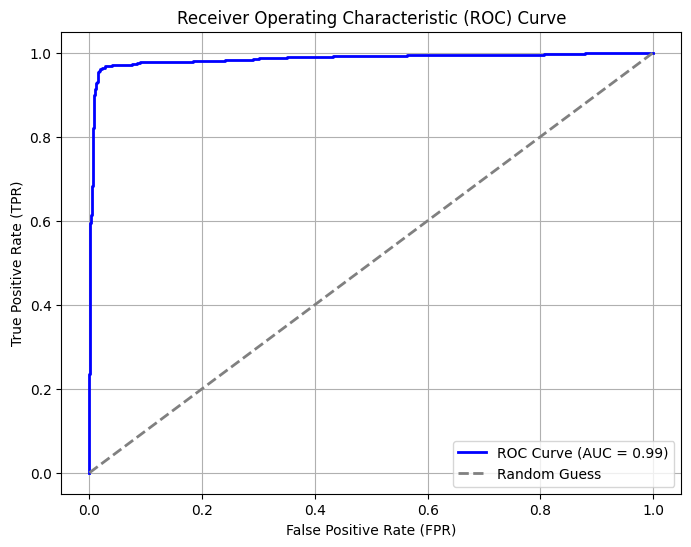

AUC: 0.99


In [16]:


# Get predicted probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_val)[:, 1]  # Probabilities for class 1

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the AUC score
print(f"AUC: {roc_auc:.2f}")

In [17]:
#Confirm if the model isnt overfitting!

# Evaluate on training set
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Evaluate on validation set
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Training Accuracy: 0.98
Validation Accuracy: 0.97
